#TensorFlow final project group 40: Chess AI

##import packages and define some global methods

In [18]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import copy
!pip install pympler
from pympler import asizeof
from collections import Counter
from timeit import timeit
import os
from google.colab import drive
import random
import time
import matplotlib.pyplot as plt
#drive.mount('/content/gdrive')
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#method to measure time it takes to train for example
def get_time(start):
  current = time.time()
  time_steps = current - start
  return round(time_steps, 5)

def get_average(list):
  return sum(list) / len(list)

##Board

In [4]:
class Chessboard():
  def __init__(self):
    ''' The chessboard class represents a gamestate of the game chess. It stores an 8x8 array which holds the pieces currently in play for each player (black and white).
    This is mainly a container for the array and other variables that we need to keep track of. It also has some basic functionalities. 
    Most importantly it does some logic checking for moves and has a function to transform the stored information to a tensor.
    '''
    self.pieces = []
    self.fiftyMoveRule = 0
    self.gameOver = False
    self.white_to_move = True
    self.kingpositions = [[7,4],[0,4]]
    self.value_advantage = 0.0001
    self.played_moves = []
    self.prepare_board()
    self.visited_boardstates = {}

  def __str__(self):
    prettyprint = { "None" : "  ", "wRook": "wR", "bRook": "bR", "wKnight" : "wk", "bKnight" : "bk", "wBishop" : "wB",
                        "bBishop" : "bB", "wQueen" : "wQ", "bQueen" : "bQ", "wKing" : "wK!", "bKing" : "bK!", "bPawn" : "bP", "wPawn" : "wP"}
    arr = []
    for e in self.board:
      arr.append([prettyprint[str(i)] for i in e])    
    return str(np.array(arr))

  def reset(self):
    #reset current state to start state
    self.pieces = []
    self.fiftyMoveRule = 0
    self.gameOver = False
    self.white_to_move = True
    self.kingpositions = [[7,4],[0,4]]
    self.value_advantage = 0.0001
    self.played_moves = []
    self.prepare_board()
    self.visited_boardstates = {}
    
  def prepare_board(self):
    #setup the array with pieces correctly for a new game
    self.board = np.empty([8,8],dtype = object)
    self.board[0] = [Rook( True ),Knight( True),Bishop( True),Queen( True),King( [0,4], True),Bishop( True),Knight( True),Rook( True)]
    self.board[7] = [Rook( False),Knight( False),Bishop( False),Queen( False),King( [7,4], False),Bishop( False),Knight( False),Rook( False)]
    self.board[1] = [Pawn((1,0), True),Pawn((1,1), True),Pawn((1,2), True),Pawn((1,3), True),Pawn((1,3), True),Pawn((1,5), True),Pawn((1,6), True),Pawn((1,7), True)]
    self.board[6] = [Pawn((6,0), False),Pawn((6,1), False),Pawn((6,2), False),Pawn((6,3), False),Pawn((6,4), False),Pawn((6,5), False),Pawn((6,6), False),Pawn((6,7), False)]

  def prepare_testboard(self):
    #special boardstate we used for testing
    self.board = np.empty([8,8],dtype = object)                               ##############################
    self.board[0] = [Rook( True ),Knight( True),Bishop( True),Queen( True),King( [0,4], True),Bishop( True),Knight( True),Rook( True)]
    self.board[7] = [Rook( False),Knight( False),Bishop( False),Queen( False),King( [7,4], False),Bishop( False),Knight( False),Rook( False)]
  
  def prepare_checkmateinone(self):
    #special boardstate we used for testing
    #self.kingpositions = [[7,4],[0,2]]
    self.board = np.empty([8,8],dtype = object)                               ##############################
    self.board[0] = [Rook( True ),Knight( True),Bishop( True),Queen( True),King( [0,4], True),Bishop( True),Knight( True),Rook( True)]
    self.board[6] = [Pawn( (6,0),False),Pawn( (6,1),False),Pawn( (6,2),False),Pawn( (6,3),False),Pawn( (6,4),False),None,Pawn((6,6),False),Pawn((6,7), False)]
    self.board[1] = [None,Pawn( (1,1),True),Pawn((1,2), True),Pawn((1,3), True),None  ,None,None,None]
    self.board[4][7] = Queen(True)
    self.board[5][6] = Rook(True)
    self.board[7] = [Rook( False),Knight( False),Bishop( False),Queen( False),King( [7,4], False),Bishop( False),Knight( False),Rook( False)]
    print(self)

  # def changeKingPosition(self, is_white, position):
  #   if (is_white):
  #     self.white_king = position
  #   else: self.black_king = position

  def getPiece(self, position):
    return self.board[position[0],position[1]]

  def getMoves(self):
    # get all pieces of correct color and get moves for these. The moves returned by this check mainly for move logic like is inside array and not being able to take own pieces
    # but not wether the king would be left in check after the move. This is done in the Boardmanager class. In hindsight maybe not needed but this is how we did it.
    if self.white_to_move:
      piece_positions = np.argwhere(self.board == True)
      self.pieces = self.board[self.board == True] #np.where(self.board == True)
    else:
      piece_positions = np.argwhere(self.board == False)
      self.pieces = self.board[self.board == False]
    all_moves = []
    for position in piece_positions:
      moves = self.getPiece(position).getMoves(position, self)
      all_moves = all_moves + moves
    return all_moves    

  def isInside(self,y,x):
    # index inside of array lenght
    if (y in range(0,8) and x in range(0,8)):
      return True
    return False

  def kingInCheck(self, dont_change_perspective = False, prin = False):
    # this method checks wether the king is in check in current position.
    # dont_change_perspective is a parameter to change wich king (black/white) would be checked.
    king = self.kingpositions[int( not self.white_to_move)]
    if dont_change_perspective:
      king = self.kingpositions[int(self.white_to_move)]
    try:
      val = self.getPiece(king).isChecked(king, self)
    except:
      print(f"The Position of the King got Lost {self}+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return val

  def movePiece(self, move, actual_move = True):
    # This method is responsible for moving a piece. we have to do multiple logic checks for example for promoting a pawn or castling the king
    if (len(move)==3):
      #when lenght of move is 3 the last element of the move represents either a Promotion of a pawn to that piece
      #or another pawn which has to get taken onpassant
      onpassant_or_promotion_piece = move[2]
      #onpassant
      if (isinstance(onpassant_or_promotion_piece,Pawn)):
        self.value_advantage -= onpassant_or_promotion_piece.value
        self.board[onpassant_or_promotion_piece.position[0],onpassant_or_promotion_piece.position[1]] = None
      #promotion of pawn
      else:
        self.board[move[0][0],move[0][1]] = move[2]
        self.fiftyMoveRule = 0
        self.value_advantage -= move[2].value
    #move piece from location 0 to 1
    try:
      moving_piece = self.board[move[0][0],move[0][1]]
      moving_piece.move([move[1][0],move[1][1]])
      if(isinstance(moving_piece, Pawn)):
        self.fiftyMoveRule = 0
    # This exception deals with Castling moves for which an attribute error occurs due to indexing, since they are basically 2 moves in one
    except AttributeError as e:
      #we treat the castling move like 2 moves
      for partmove in move:
        self.movePiece(partmove)
      self.white_to_move = not self.white_to_move
      # Optional line of code so we append Castling-moves as one move
      self.played_moves.append([self.played_moves.pop(),self.played_moves.pop()])
      self.addBoardstateToSeen()
      return
    try:
      # if we take a piece change the relöative advantage for piece value of the board
      self.value_advantage -= self.getPiece(move[1]).value
      self.fiftyMoveRule = 0
    except: pass
    #move piece from starting position to end position
    self.board[move[0][0],move[0][1]] = None
    self.board[move[1][0],move[1][1]] = moving_piece
    #append the played move to all played moves
    self.played_moves.append(move)
    self.fiftyMoveRule = self.fiftyMoveRule +1
    #if the king moved update its position
    if (str(moving_piece) in ["wKing", "bKing"]):
      self.kingpositions[int(self.white_to_move)] = [move[1][0],move[1][1]]
    self.white_to_move = not self.white_to_move
    self.addBoardstateToSeen()

  def copyBoard(self):
    # This method returns a complete copy of self. We need to do this to try out moves for example to get legal moves, without changing the original boardstate
    # This is probably slow but we did not find another way to do this easily.
    new_board = copy.deepcopy(self)
    return new_board

  def transform_board(self, board, white_to_move = True):
    vocab = {"None" : 0, "wPawn" : 1, "wRook" : 2, "wKnight" : 3, "wBishop" : 4, "wQueen" : 5, "wKing" : 6, "bPawn" : 7, "bRook" : 8, "bKnight" : 9, "bBishop" : 10, "bQueen" : 11, "bKing" : 12}
    int_board = []
    for row in board:
      for piece in row:
        int_board.append(vocab[str(piece)])                 
    #experimental
    tf_board = tf.convert_to_tensor(int_board)
    oh_board = tf.one_hot(tf_board, 13)   #shape: (64,13)
    # add if white or black is to move to tensor
    if white_to_move:
      val = tf.ones((64,1))
    else :
      val = tf.zeros((64,1))
    oh_board = tf.concat([oh_board, val], axis = 1)
    oh_board = tf.expand_dims(oh_board, axis = 0) 
    #returns tensor of shape (64,14)
    return oh_board

  def getID(self, string = True):
    #method to get a ID for current board to check if boardstate was encountered already
    vocab = {"None" : 0, "wPawn" : 1, "wRook" : 2, "wKnight" : 3, "wBishop" : 4, "wQueen" : 5, "wKing" : 6, "bPawn" : 7, "bRook" : 8, "bKnight" : 9, "bBishop" : 10, "bQueen" : 11, "bKing" : 12}
    int_board = []
    if (string):
      s = ""
      for row in self.board:
        for piece in row:
          s += str(vocab[str(piece)])
      white_to_move = int(self.white_to_move)
      s += str(white_to_move)
      #s += str(int(self.getPiece(self.kingpositions[white_to_move]).has_moved))
      return s
    for row in self.board:
      for piece in row:
        int_board.append(vocab[str(piece)])                 #shape: (64,13)
    return  int_board#dic#tuple(int_board)#int_board

  def addBoardstateToSeen(self):
    #adds boardstate to seen boardstates and increases its counter
    id = self.getID(True)
    self.addCountToDict(int(id))

  def addCountToDict(self, id):
    if (id in self.visited_boardstates.keys()):
      self.visited_boardstates[id] += 1
    else:
      self.visited_boardstates[id] = 1

##Board manager

In [5]:
class Boardmanager():
  def __init__(self):
    self.board = Chessboard()
    self.game_over = False
    # pieces that could attack either horizontal or diagonal
    self.horizontalAttacker = ["bRook","bQueen","wRook","wQueen"]
    self.diagonalAttacker = ["bBishop","bQueen","wBishop","wQueen"]
    self.moves = []

  def getMoves(self, board):
    self.moves = []
    all_moves = board.getMoves()
    for move in all_moves:
      # This part is to check for illigal moves leaving or moving the King in check
      new_board = board.copyBoard()
      # Attribute error occurs when trying to move a castling move, because it are 2 moves in one, which gives an error when trying to index
      try:
        new_board.movePiece(move,True)
      except AttributeError as e:
        #We do not need to test for Checks because that is done inside the castling method
        print("faulty move: {} kingposition:{} board:{}".format(move,new_board.kingpositions,str(new_board)))
        print(f"Kinggot lost with excetpion{e}")
        pass
      # if the king is not in check after expanding the board with the specific move it is a legal move
      if not (new_board.kingInCheck()):
        self.moves.append(move)
    return self.moves

  def getMovesAgent(self, board):
    # This method is used by the agent. The main difference is that in addition to moves it returns the 
    self.moves = []
    all_moves = board.getMoves()
    #experimental
    expanded_boards = []
    for move in all_moves:
      # This part is to check for illigal moves leaving or moving the King in check
      new_board = board.copyBoard()
      # Attribute error occurs when trying to move a castling move, because it are 2 moves in one, which gives an error when trying to index
      try:
        new_board.movePiece(move,True)
      except AttributeError as e:
        print("tried to expand a castling move. {}".format(e))
        print("faulty move: {} kingposition:{} board:{}".format(move,new_board.kingpositions,str(new_board)))
        print(f"Kinggot lost with excetpion{e}")
        pass
      try: 
        if not (new_board.kingInCheck()):
          self.moves.append(move)
          #experimental
          expanded_boards.append(new_board)
      except AttributeError as e:
        print("tried to expand a castling move????? {}".format(e))
        print("faulty move: {} kingposition:{} board:{}".format(move,new_board.kingpositions,str(new_board)))
        print(f"Kinggot lost with excetpion{e}")
        pass 
    return (self.moves, expanded_boards)
 
  def gameOver(self, board):
    #first we check if there are legal moves in the current position
    if (self.staleMate(board)):
      print("Stalemate")
      #if not and the king is currently in check game ends with checkmate
      if (board.kingInCheck(dont_change_perspective = True)):
        self.game_over = True
        print("Won by checkmate : {}".format(self.game_over))
        print(len(board.pieces))
        return True, -1
      else:
        ## else game ends with a stalemate/Draw
        self.game_over = True
        print("Draw by stalemate : {}".format(self.game_over))
        print(len(board.pieces))
        return True, 0
    if (len(board.pieces)<=3):
      # check for insufficient material not very suffisticated but speeds up learning because ends games at some point
      # The player with 3 or less pieces King inclusive loses the game
      self.game_over = True
      print("Won by insufficient Material : {}".format(self.game_over))
      print(len(self.board.pieces))
      return True, -1
    if (3 in board.visited_boardstates.values()):
      # If the same Boardstate is visited 3 times the game ends with a draw due to repetition
      self.game_over = True
      print("Draw by repitition : {}".format(self.game_over))
      return True, 0
    if (board.fiftyMoveRule > 99):
      # if in 50 moves of each player neither has taken a piece or pushed a pawn the game ends with a draw
      self.game_over = True
      print("Draw by shuffling-Pieces : {}".format(self.game_over))
      return True, 0
    return False, 0

  def staleMate(self, board):
    if ( not bool(self.moves)):
      return True
    return False

  def expand_with_move(self,board,move):
    #copys current state and performs move on it 
    new_board = board.copyBoard()
    new_board.movePiece(move,True)
    return new_board

##Replay Buffer

In [6]:
# Experience Replay buffer that stores sampled trajectories (played games) taken from the Really framework
class Replay_buffer():
    def __init__(self, size, keys):
        self.buffer = {}
        for k in keys:
            self.buffer[k] = []
        self.size = size
        self.keys = keys

    def put(self, data_dict):
        dict_keys = list(data_dict.keys())

        current_len = len(self.buffer[self.keys[0]])
        add_len = len(data_dict[dict_keys[0]])
        new_len = current_len + add_len

        if new_len >= self.size:
            pop_len = new_len - self.size

            for k in self.buffer.keys():
                self.buffer[k] = self.buffer[k][pop_len:]

        for k in dict_keys:
            self.buffer[k].extend(data_dict[k])

        return self.buffer

    def sample(self, num):

        seed = random.randint(0, 100)
        sample = {}
        for k in self.buffer.keys():
            random.seed(seed)
            sample[k] = np.asarray(random.choices(self.buffer[k], k=num))
        return sample

###SearchTree

In [7]:
class Edge():
  def __init__(self, inNode, outNode, action, prior ):
    '''Edges connect Nodes in the searchtree. They have stats visits which keeps track of how often we walked along the edge.
    Worth is the summed value of of boardstates that have been reached via this edge
    Advantage is the avarage Worth
    Probability is a relic from the alphaZero approach
    '''
    self.inNode = inNode
    self.outNode = outNode
    self.action = action
    self.white_to_move = inNode.board.white_to_move
    self.stats =  {
					'visits': 0, #N
					'Worth': 0, #W
					'Advantage': 0, #Q Experimental
					'Probability': prior} #P

class Node():
  '''Nodes store a boardstate and a list of edges that represents actions possible from that boardstate'''
  def __init__(self, board):
    self.board = board
    self.edges = []
  
  def isLeaf(self):
    return (len(self.edges)<1)

class Tree():
  def __init__(self, board):
    self.root = Node(board)
    self.tree = {}
    self.addNode(self.root, int(self.root.board.getID()))

  def addNode(self, node, id):
    #add a new node to the tree based on its ID
    self.tree[id] = node

  def traverseTree(self, _epsilon = 0.8):
    '''Starting from the Root traverse the search-tree until we reach a leafnode. When walking through our tree,
    nodes are choosen relative to their estimated value and the number of times we have already visited them.
    Additionaly moves get a base exploration value if we are in the root-node.
    This gives us a good exploration-exploitation tradeoff, while expanding possible future moves.
    The Leafnode we reach is the node, we expect to have the highest information gain. It is returned to be subsequently expanded.
    '''
    path = []
    current_node = self.root
    done = 0
    value = 0
    max_depth = 5
    i = 0
    #We walk through the searchtree until we reach a leafnode. The leafnode we reach will be subsequently evaluated and expanded (-->agent)
    while not (current_node.isLeaf()):
      maxInformationgain = -9999
      if current_node == self.root:
        epsilon = _epsilon
      else: 
        epsilon = 0
      summed_visits = 0
      for action, edge in current_node.edges:
        # measure for how often we visited all other states from the current state
        summed_visits += edge.stats["visits"]
      
      for idx, (action, edge) in enumerate(current_node.edges):
        probability_visit_discount = edge.stats["Worth"] * np.sqrt(summed_visits)/(1 + edge.stats["visits"]) + epsilon /(1 + edge.stats["visits"])
        Advantage = edge.stats["Advantage"]

        if Advantage + probability_visit_discount > maxInformationgain:
          #choose the next edge based on expected value and visit frequency
          maxInformationgain = Advantage + probability_visit_discount
          nextAction = action
          nextEdge = edge
      i +=1
      if (i>max_depth): 
        break
      current_node = nextEdge.outNode
      path.append(nextEdge)
    return current_node, path

  def backFill(self, leaf, value, path):
    '''after a Leafnode got reached and evaluated, update all visited edges along the walked path with the new value'''
    playing_white = leaf.board.white_to_move
    #print("Backfilling:")
    for edge in path:
      white_to_move = edge.white_to_move
      #We have to look at the estimated value from the perspective of the current player. That changes with every move/edge we take or walk along
      if white_to_move == playing_white:
       direction = 1
      else:
        direction = (-1)
      #increase visit count and update estimated value
      edge.stats['visits'] = edge.stats['visits'] + 1
      edge.stats['Worth'] = edge.stats['Worth'] + value * direction
      edge.stats['Advantage'] = edge.stats['Worth'] / edge.stats['visits']


##Pieces

###Base class

In [8]:
class Piece():
  ''' Base Piece brings some basic functionalities important for moving. All other Pieces inherit from base piece and make use, in some form or another, of the move actions of the BasePiece'''
  def __init__(self, val = 1,is_white = True):
    #self.val = val
    self.diagonalMoves = [(1,1),(1,-1),(-1,1),(-1,-1)]
    self.horizontalMoves = [(1,0),(0,1),(-1,0),(0,-1)]
    self.knightJumps = [(1,2),(1,-2),(-1,2),(-1,-2),(2,1),(2,-1),(-2,1),(-2,-1)]
    self.__is_white = is_white
  
  def __eq__(self,other):
    return (self.__is_white == other)

  def getColor(self):
    return self.__is_white
  
  def getMoves(self, position, board):
    return

  def yieldExpandedSteps(self, position, steps, board):
    # we start expanding in direction of steps
    for ystep,xstep in steps:
      y = position[0]+ystep
      x = position[1]+xstep
      #as long as we are inside of bounds we return the square at the specific location
      while (board.isInside(y,x)):
        piece = board.getPiece((y,x))        
        yield piece, [y,x]
        # if the square we yielded is not empty we stop expanding in this direction, since we cannot move through pieces
        if (piece is not None):
          break
        y = y + ystep
        x = x + xstep

  def yieldExpandedStepsOnes(self, position, steps, board):
    for ystep,xstep in steps:
      y = position[0]+ystep
      x = position[1]+xstep
      if (board.isInside(y,x)):
        piece = board.getPiece((y,x))
        yield piece

  def getDiagonalMoves(self, starting_position, board):
    moves = []
    for piece, position in self.yieldExpandedSteps(starting_position, self.diagonalMoves, board):
      move = [starting_position, position]
      # if we find a piece only append the move to that square if it is an "enemy" piece
      try:
        if (piece.getColor() != self.getColor()):
          moves.append(move)
      # we found an empty square so we can move there
      except:
          moves.append(move)
    return moves

  def getHorizontalMoves(self, starting_position, board):
    moves = []
    for piece, position in self.yieldExpandedSteps(starting_position, self.horizontalMoves, board):
      move = [starting_position, position]
      try:
        if (piece.getColor() != self.getColor()):
          moves.append(move)
      except:
          moves.append(move)
    return moves

  def getMovesKnight(self, starting_position, board):
    moves = []
    for ystep,xstep in self.knightJumps:
      y = starting_position[0]+ystep
      x = starting_position[1]+xstep
      move = [starting_position, [y,x]]
      if (board.isInside(y,x)):
        try:
          if (board.getPiece([y,x]).getColor() != self.getColor()):
            moves.append(move)
        except: moves.append(move)
    return moves
  
  def move(self, move):
    self.position = move

  def getPosition(self):
    return self.position

###Bishop, Knight, Rook and Queen

In [9]:
class Bishop(Piece):
  def __init__(self, is_white = True):
    Piece.__init__(self, 3, is_white)
    self.diagonalMoves = [(1,1),(1,-1),(-1,1),(-1,-1)]
    if (is_white): self.value = 3
    else: self.value = -3

  def __repr__(self):
    #every piece represents itself with name and a prefix for its color
    if (self.getColor()):
      return "wBishop"#
    return "bBishop"
  
  def getMoves(self, starting_position, board):
    return Piece.getDiagonalMoves(self, starting_position, board)
        

class Knight(Piece):
  def __init__(self, is_white = True):
    Piece.__init__(self, 3, is_white)
    if (is_white): self.value = 3
    else: self.value = -3
  def __repr__(self):
    if (self.getColor()):
      return "wKnight"#
    return "bKnight"

  def getMoves(self, starting_position, board):
    
    return Piece.getMovesKnight(self, starting_position, board)

class Rook(Piece):
  def __init__(self, is_white = True):
    Piece.__init__(self, 5, is_white)
    self.has_moved = False
    if (is_white): self.value = 5
    else: self.value = -5

  def __repr__(self):
    if (self.getColor()):
      return "wRook"#
    return "bRook"
  
  def getMoves(self, starting_position, board):
    
    return Piece.getHorizontalMoves(self, starting_position, board)
  
  def move(self, destiantion):
    self.has_moved = True


class Queen(Piece):
  def __init__(self, is_white = True):
    Piece.__init__(self, 9, is_white)
    if (is_white): self.value = 9
    else: self.value = -9
  
  def __repr__(self):
    if (self.getColor()):
      return "wQueen"#
    return "bQueen"

  def getMoves(self, starting_position, board):
    return Piece.getDiagonalMoves(self, starting_position, board) + Piece.getHorizontalMoves(self, starting_position, board)

###King

In [10]:
class King(Piece):
  def __init__(self, position, is_white = True):
    Piece.__init__(self, -1, is_white)
    self.position = position
    self.has_moved = False
    self.horizontalAttacker = ["bRook","bQueen","wRook","wQueen"]
    self.diagonalAttacker = ["bBishop","bQueen","wBishop","wQueen"]
    if (is_white): self.value = 100
    else: self.value = -100

  def __repr__(self):
    if (self.getColor()):
      return "wKing"
    return "bKing"

  def getMoves(self, starting_position, board):
    moves = []
    # castling is only possible if the king has not moved yet
    if (not self.has_moved):
      self.castling(starting_position, board, moves)
    for ystep, xstep in self.diagonalMoves + self.horizontalMoves:
      y = starting_position[0]+ystep
      x = starting_position[1]+xstep
      move = [starting_position,[y,x]]
      if (board.isInside(y,x)):
        try:
          if (board.getPiece([y,x]).getColor() != self.getColor()):
            moves.append(move)
        except: moves.append(move)
    return moves
  
  def move(self, destination):
    self.has_moved = True
    self.position = destination

  def castling(self, starting_position, board, moves):
    if (self.isChecked(starting_position, board)): return
    start_y = starting_position[0]
    start_x = starting_position[1]
    for piece, _position in self.yieldExpandedSteps(starting_position, [(0,1)], board):
      # if the piece we find is a rook castling might be possible
      try:
        if (str(piece) in ("bRook","wRook")[int(self.getColor())] and not piece.has_moved):
          #Rook must not have moved before aswell and no square in the way of the king can be under attack
          if (not self.isChecked((start_y, start_x +1), board) and not self.isChecked((start_y, start_x +2), board)):
            # append first the king-move and then the rook move. Basically castling moves are two moves in one
            move = [[starting_position, (start_y, start_x+2)], [_position, (start_y, start_x + 1)]]
            moves.append(move)
      except Exception as e: 
        print("castling exception: {}".format(e))
        pass
    for piece, _position in self.yieldExpandedSteps(starting_position, [(0,-1)], board):
      try:
        if (str(piece) in ("bRook","wRook")[int(self.getColor())] and not piece.has_moved):
          if (not self.isChecked((start_y, start_x - 1), board) and not self.isChecked((start_y, start_x - 2), board)): 
            move = [[starting_position,(start_y, start_x - 2)], [_position,(start_y, start_x - 1)]]
            moves.append(move)
      except Exception as e: 
        print("castling exception: {}".format(e))
        pass
                
  def isChecked(self, starting_position, board, prin = False):
    '''This method checks wether the King is under attack. There are different ways to check this but we decided to just let the king do every move possible from its possition
    and then check if an enemy piece is found that could to that move. If so the king is checked, if all logic checks pass the king is not checked.
    '''
    if (prin): print("Kings position: {}".format(starting_position))
    if (prin): print("horizontal-checks")
    for piece, position in self.yieldExpandedSteps(starting_position, self.horizontalMoves, board):
      #if (piece is not None):
      try:
        if (piece.getColor() != self.getColor() and str(piece) in self.horizontalAttacker):
          if (prin): print("horizontal-checks from Piece at position: {}".format(piece, position))
          return True
      except:
        pass
    if (prin): print("diagonal-checks")
    for piece, position in self.yieldExpandedSteps(starting_position, self.diagonalMoves, board):
      if (piece is not None):
        try:
          if (piece.getColor() != self.getColor() and str(piece) in self.diagonalAttacker):
            if (prin): print("Diagonal check from piece {} at position : {}".format(piece, position))
            return True
        except:
          pass
    if (prin): print("Knight checks")
    for piece in self.yieldExpandedStepsOnes(starting_position, self.knightJumps, board):
      if (piece is not None):
        try:
          if (piece.getColor() != self.getColor() and str(piece) in ["wKnight","bKnight"]):
            if (prin): print("Knight at position : {}".format(piece))              
            return True
        except:
          pass
    if (prin): print("Pawn-checks")
    for y,x in [[(-1,1),(-1,-1)],[(1,1),(1,-1)]][int(self.getColor())]:
      y_pos = starting_position[0] + y
      x_pos = starting_position[1] + x
      if (prin): print(y_pos,x_pos)
      if (board.isInside(y_pos,x_pos)):
        try:
          p = board.getPiece((y_pos,x_pos))
          #print("---------------------------------------------------------------------------------------------------------------------PAWN at Positions: {}".format((y_pos,x_pos)))
          if (str(p) in ["wPawn", "bPawn"] and p.getColor() != self.getColor()):
            if (prin): print("pawn at position : {}".format((y_pos,x_pos)))            
            return True
        except:
          pass
    if (prin): print("Knight checks")
    for piece in self.yieldExpandedStepsOnes(starting_position, self.diagonalMoves + self.horizontalMoves, board):
      if (piece is not None):
        try:
          if (piece.getColor() != self.getColor() and str(piece) in ("wKing","bKing")):
            if (prin): print("King at position : {}".format(piece))            
            return True
        except:
          pass
    return False


###Pawn

In [11]:
class Pawn(Piece):
  def __init__(self, position, is_white = True):
    Piece.__init__(self, 1, is_white)
    self.position = position
    self.has_moved = False
    if (is_white):
      #set the direction in which the pawn can move
      self.direction = 1
      self.value = 1
    else: 
      self.direction = -1
      self.value = -1

  def __repr__(self):
    if (self.getColor()):
      return "wPawn"#
    return "bPawn"#"Pawn"

  def getMoves(self, starting_position, board):
    moves = []
    y = starting_position[0]
    x = starting_position[1]
    # Check wether we would leave the board with a move
    if y in range(1,7):
      #Forward movement with check if we can move two squares
      if (board.getPiece([y + self.direction, x]) is None):
        #check for promotion
        if (y + self.direction in [0,7]):
          moves.append([starting_position, (y + self.direction,x), Queen(self.getColor())])
          moves.append([starting_position, (y + self.direction,x), Knight(self.getColor())])
          moves.append([starting_position, (y + self.direction,x), Rook(self.getColor())])
          moves.append([starting_position, (y + self.direction,x), Bishop(self.getColor())])
        else:
          moves.append([starting_position, (y + self.direction,x)])
        if not (self.has_moved):
          if (board.getPiece([y + 2*self.direction, x]) is None):
              moves.append([starting_position,(y + 2*self.direction,x)])
      # taking with a pawn is different than moving a pawn (diagonal/horizontal)
      # we have to check if we are at the edge of the board
      if (x<7 and board.getPiece([y + self.direction, x + 1]) is not None):
        try:
          if (board.getPiece([y + self.direction, x + 1]).getColor() != self.getColor()):
            if (y + self.direction in [0,7]):
              moves.append([starting_position, (y + self.direction, x + 1), Queen(self.getColor())])
              moves.append([starting_position, (y + self.direction, x + 1), Knight(self.getColor())])
              moves.append([starting_position, (y + self.direction, x + 1), Rook(self.getColor())])
              moves.append([starting_position, (y + self.direction, x + 1), Bishop(self.getColor())])
            else:
              moves.append([starting_position, (y + self.direction, x + 1)])
        except: pass
      if (x>0 and board.getPiece([y + self.direction, x - 1]) is not None):
        try:
          if (board.getPiece([y + self.direction, x - 1]).getColor() != self.getColor()):
            #Promotion
            if (y + self.direction in [0,7]):
              moves.append([starting_position, (y + self.direction, x - 1), Queen(self.getColor())])
              moves.append([starting_position, (y + self.direction, x - 1), Knight(self.getColor())])
              moves.append([starting_position, (y + self.direction, x - 1), Rook(self.getColor())])
              moves.append([starting_position, (y + self.direction, x - 1), Bishop(self.getColor())])
            else:
              moves.append([starting_position, (y + self.direction, x - 1)])
        except: pass
      #On-passant implementation
      try:
        last_move = board.played_moves[-1]
      except:
        #print("Pawn-Onpassant exception, probably because no moved played as of yet")
        return moves
      try:
        
        if (last_move[1][0] in [[3,4][int(self.getColor())]] and ((last_move[0][0] - last_move[1][0])in [2,-2])):
          try:
            piece = board.getPiece(last_move[1])
            #if the piece ended up next to us and is a pawn
            if ( isinstance(piece,Pawn) and piece.getColor() != self.getColor()):
              _y,_x = last_move[1]
              if (x in [_x+1,_x-1] and y == _y):
                #last move is to take the pawn
                moves.append([starting_position,(y+self.direction, _x), piece])
          except: pass
      except: pass
    return moves
  
  def move(self, destination):
    self.has_moved = True
    self.position = destination
  


##Agent

In [27]:
class Agent():
  '''Agent class that takes as argument a NN-architecture to use. It learns to play chess by trying to predict the gameoutcome in every state,
  performing a Monte-carlo Treesearch, and choosing a move that leads to a state with a high predicted value. It is trained on its predictions and the actual gameoutcome.
  '''
  def __init__(self, plays_white, boardmanager, NN_architecture = "mixed"):
    self.plays_white = plays_white
    self.boardmanager = boardmanager
    self.searchtree = None
    if NN_architecture == "mixed":
      self.NN = ChessBot_mix()
    elif NN_architecture == "dense":
      self.NN = ChessBot_dense()
    elif NN_architecture in ["conv","convolution"]:
      self.NN = ChessBot_conv()
    else:
      self.NN = ChessBot()
    self.tau = 0
    self.optimizer = tf.keras.optimizers.Adam(0.001)

  def chooseMove(self, values, tau):
    #choose a move that maximes the estimated value
    moves = np.argwhere(values == max(values))
    move_idx = np.random.choice(moves[0])
    value = values[move_idx]
    #print(f"val in estimator for agent : {value}")
    return move_idx, value

  def getValueEstimate(self, board):
    #predict the value of a boardstate
    nn_board = board.transform_board(board.board, board.white_to_move)
    val = self.NN(nn_board)
    return val

  def act(self,board, num_steps=20):
    # We check wether the current boardstate is already in our searchtree
    # if so we we set the root to the already seen state in the searchtree
    # if not we create a new searchtree with the current state as rootnode
    if (self.searchtree == None or int(board.getID()) not in self.searchtree.tree):
      self.searchtree = Tree(board)
    else:
      self.searchtree.root = self.searchtree.tree[int(board.getID())]
    # Move throught the searchtree for a specific number of iterations
    # n_steps has huge influence on time consumption and performance of Agent
    for step in range(num_steps):
      self.expandsearch1()
    # values are the estimated values for all moves possible in current state
    values = self.getActionValues(1) 
    #pick a specific action
    move_idx, value = self.chooseMove( values, self.tau)
    move = self.searchtree.root.edges[move_idx][0]
    print(f"highest move-value for current state is: {move} with value: {value}")
    state = board.transform_board(board.board)
    print(self.boardmanager.board)
    #what we need for training is the current state and final return. we get the final return after episode finished
    return state, move 

  def getActionValues(self, tau):
    # look through all edges and return their advantage
    edges = self.searchtree.root.edges
    values = np.zeros(len(edges), dtype=np.float32)
    for idx, (action, edge) in enumerate(edges):
      values[idx] = edge.stats["Advantage"]
    return values

  def expandsearch1(self, board = None):
    #Expand our searchtree by moving to a leafnode
    leaf, path = self.searchtree.traverseTree()
    #Evaluate the leafnode and create edges for leafnode
    value = self.evaluateLeafNode(leaf)
    #Backpropagate the value of leafnode through our searchtree and update values accordingly
    self.searchtree.backFill(leaf, value, path)

  def evaluateLeafNode(self,leaf):
    moves, boards = self.boardmanager.getMovesAgent(leaf.board)
    #we check wether the boardstate is a final state, if so we stop expanding and return the worth of terminal state (-1,0,1)
    done, value = self.boardmanager.gameOver(leaf.board) #used to be self.boardmanager.board
    if not done:
      #estimate value of leaf
      value = self.getValueEstimate(leaf.board)
      # We expand the searchtree on level of the leafnode with all possible moves in that state
      for move, board in zip(moves,boards):
        id = int(board.getID())
        if not (id in self.searchtree.tree):
          node = Node(board)
          self.searchtree.addNode(node, id)
        else:
          node = self.searchtree.tree[id]
                    # innode, outnode
        newEdge = Edge(leaf, node, move, prior = 1)
        leaf.edges.append((move, newEdge))
    if (done):
      print(f"leafnode {leaf.board}is terminal boardstate with finishvalue of {value}")
    return value

  def train_step(self, state, target):
    #Train the Model with minor distinction for specific model
    with tf.GradientTape() as tape:
      if isinstance(self.NN, ChessBot_dense):
        state = tf.squeeze(state, axis = 1)
      #if isinstance(self.NN, ChessBot_mix):
      expectation = self.NN(state)
      loss = tf.keras.losses.MSE(target, expectation)
      gradients = tape.gradient(loss, self.NN.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.NN.trainable_variables))
    return loss
  
  def saveModel(self,prefix = "0"):
    #self.NN.save(os.getcwd())
    path = 'saved_model_weights_chess' + prefix
    self.NN.save_weights(path, overwrite = True)

##Models

###Dense Model

In [13]:
class ChessBot_dense(tf.keras.Model):
    def __init__(self):
        '''A Neural-Network only using dense_layers '''
        super(ChessBot_dense, self).__init__()
        self.dense_layers =  [tf.keras.layers.Dense(units = 256, activation = None),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.LeakyReLU(),
                              #tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same'),
                              #tf.keras.layers.Dropout(0.1),
                              tf.keras.layers.Dense(units = 128, activation = None),
                              #tf.keras.layers.Reshape((64,128)),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.LeakyReLU(),
                              tf.keras.layers.Dense(units = 64 , activation = None),
                              #tf.keras.layers.Reshape((64,32)),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.LeakyReLU(),
                              tf.keras.layers.Dense(units = 32 , activation = None),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.LeakyReLU(),
                              tf.keras.layers.Dense(units = 16 , activation = None),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.LeakyReLU(),
                              tf.keras.layers.Flatten(),
                              # tf.keras.layers.Reshape((64,1)),
                              tf.keras.layers.Dense(units = 1, activation = "tanh", use_bias = False)]
    
    def __call__(self, input):
        for layer in self.dense_layers:
          input = layer(input)
        return input

###Convolutional model

In [14]:
class ChessBot_conv(tf.keras.Model):
    def __init__(self):
        '''A Neural-Network only using convolutional_layers with one dense-layer for the output '''
        super(ChessBot_conv, self).__init__()
      
        self.conv_layers =  [tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = None),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                             tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = None),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                             tf.keras.layers.Conv2D(filters = 64 , kernel_size = 3, padding = 'same', activation = None),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                             tf.keras.layers.Conv2D(filters = 32 , kernel_size = 3, padding = 'same', activation = None),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                             tf.keras.layers.Conv2D(filters = 16 , kernel_size = 3, padding = 'same', activation = None),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(units = 1, activation = 'tanh', use_bias = False)]
    
    def __call__(self, input):
        if len(input.shape)<4:
            input = tf.expand_dims(input, axis = 0)
        for layer in self.conv_layers:
            input = layer(input)
        return input

###Mixed model

In [15]:
class ChessBot_mix(tf.keras.Model):
    def __init__(self):
        '''A Neural-Network using a mix of convolutional and dense layers'''
        super(ChessBot_mix, self).__init__()
      
        self.mix_layers =  [
                             tf.keras.layers.Conv2D(filters = 100, kernel_size = 3, padding = 'same', activation = None),#64
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                             #tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(units = 100, activation = None),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                            
                             tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = None),#32
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                             #tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(units = 64, activation = None),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                            
                             tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = None),#16
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                             #tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(units = 32, activation = None),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                            
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(units = 1, activation = 'tanh', use_bias = False)]
    
    def __call__(self, input):
        if len(input.shape)<4:
          input = tf.expand_dims(input, axis = 0)
        for layer in self.mix_layers:
            input = layer(input)
        return input

##Test class

In [28]:
class Testclass():
  '''Test-class with different methods used during implementation to test the game-logic. The testclass is also responsible for handling the sampling of trajectories and training the agent.
  Some of the test methods might be out of date'''
  def __init__(self, NN_architecture = "mixed"):
    self.bm = Boardmanager()
    self.game_going = True
    self.agent = Agent(True, self.bm, NN_architecture)
    self.times = []
    self.losses = []

  def testFullGame(self):
    self.game_going = True
    curr_board = self.bm.board
    while (self.game_going):
      self.bm.getMoves(curr_board)
      move_idx = self.agents[0].chooseMove(curr_board)#int(curr_board.white_to_move)
      move = self.bm.moves[move_idx]
      print("choosen Move: {}".format(move))
      curr_board.movePiece(move)
      self.game_going = not self.bm.gameOver(curr_board)

  def testexpansion(self):
    self.bm.getMoves(self.bm.board)
    print(self.agents[1].expandsearch())
  
  def testCastling(self):
    self.bm.board.prepare_board()
    self.bm.board.board[0,1] = None
    self.bm.board.board[0,2] = None
    self.bm.board.board[0,5] = None
    self.bm.board.board[0,6] = None
    self.bm.board.board[0,3] = None
    self.bm.board.board[7,3] = Queen(False)
    moves = []
    ##### this test for if pieces movemed already
    #self.bm.white_to_move = False
    #self.bm.board.movePiece([(0,0),(0,1)])
    #####
    self.bm.board.getPiece([0,4]).castling((0,4),self.bm.board,moves)
    print(self.bm.board)
    print(moves)
    print(self.bm.getMoves(self.bm.board))
    #change move between 0 and 1 for testing
    print(self.bm.board.white_to_move)
    self.bm.board.movePiece(moves[1])
    print(self.bm.board)
    print(self.bm.board.white_to_move)
    print(self.bm.board.played_moves)
    print(self.bm.board.kingpositions)

  
  def testOnpassant(self):
    self.bm.board.board = np.empty([8,8],dtype = object)
    self.bm.board.board[0,4] = King([0,4])
    self.bm.board.board[7,4] = King([7,4], False)
    self.bm.board.board[1][3] = Pawn((1,3))
    self.bm.board.board[2][4] = Pawn((2,4))
    self.bm.board.board[3][4] = Pawn((3,4),False)
    self.bm.board.movePiece([[1,3],[3,3]])
    print(self.bm.board)
    self.bm.getMovesAgent(self.bm.board)
    print(self.bm.moves)
    self.bm.board.movePiece(self.bm.moves[0])
    self.bm.getMovesAgent(self.bm.board)
    print(self.bm.moves)
    print(self.bm.board)

  def testPromotion(self):
    self.bm.board.prepare_testboard()
    self.bm.board.board[6,1] = Pawn(True)
    print(self.bm.getMoves(self.bm.board))
    self.bm.board.movePiece(self.bm.moves[-3])
    print(self.bm.board)
  
  def testRepetition(self):
    self.bm.board.prepare_testboard()
    self.bm.board.movePiece(((0,1),(2,0)))
    self.bm.board.movePiece(((2,0),(0,1)))
    self.bm.board.movePiece(((0,1),(2,0)))
    self.bm.board.movePiece(((2,0),(0,1)))
    self.bm.board.movePiece(((0,1),(2,0)))
    self.bm.getMoves(self.bm.board)
    print(self.bm.board.visited_boardstates)
    print(self.bm.gameOver(self.bm.board))

  def testSearchTree(self):
    self.agents[1].act(self.bm.board)

  def collectExperience(self):
    # This method samples one trajectory of selfplay of the agent and returns the sampled trajectory
    trajectory = {}
    trajectory["state"] = []
    trajectory["finish_value"] = []
    trajectory["white_to_move"] = []
    board = self.bm.board
    # We continue playing until a terminal position is reached
    while (self.game_going):
      # let the agent decide on a move
      state, move = self.agent.act(board)
      trajectory["state"].append(state)
      trajectory["white_to_move"].append(board.white_to_move)
      #perform move and check if terminal position is reached
      board.movePiece(move)
      self.bm.getMoves(board)
      gameover, finish_value = self.bm.gameOver(board)
      if (gameover):
        print("gameOver-----------------------------------------------------------------------")
        print("player that lost had the {} Pieces and scored a reward of {}".format(["black","white"][int(board.white_to_move)], finish_value))
        # We have to create a target value for our agent/ its NN. The targetvalue is the outcome of the game (1,0,-1) for win,draw,loss
        finish_value_list = []
        if not (finish_value == 0):
          #we have to get the create a return list with the length of sampled moves and properly assign the return to the states
          for idx in range(1, len(trajectory["state"])+1):
            change = 2 * (idx%2)
            finish_value_list.append(finish_value+change)
          finish_value_list.reverse()
        else: finish_value_list = [0]* len(trajectory["state"])
        trajectory["finish_value"] = finish_value_list
        self.game_going = False
    print(board)
    print(trajectory["finish_value"])
    print(trajectory["white_to_move"])
    return trajectory

  def getOneTrajectory(self, n_epochs):
    self.initilizeBuffer(1000,["state","finish_value"])
    times = []
    for i in range(n_epochs):
      print(i)
      start = time.time()
      self.reset()
      trajectory = self.collectExperience()
      self.buffer.put(trajectory)
      print("done with playing")
      for step in range(300):
        sample = self.buffer.sample(50)
        loss = self.agent.train_step(sample["state"],sample["finish_value"])#, tf.keras.losses.MSE()
        # print("weights:-------------------------------------------------------------------------------------------------------------------")
        # print(self.agent.NN.get_weights())
      end = get_time(start)
      times.append(end)
      print("done with training")
      self.testSaveModel()
      print("done with saving")
      #print("models new weights")
      print("Needed time steps: " + str(end))
    #print(self.agent.NN.get_weights())
    print("Average of time steps needed: " + str(get_average(times)))

  def testgreed(self):
    self.bm.board.prepare_checkmateinone()
    self.collectExperience()

  def initilizeBuffer(self, size, keys):
    self.buffer = Replay_buffer(size,keys)

  def testSaveModel(self,suffix = ""):
    if len(suffix) > 0:
      self.agent.saveModel(suffix)
    else:
      self.agent.saveModel()

  def testBuffer(self):
    self.initilizeBuffer(100,["sas","sos"])
    self.buffer.put({"sas":[0,1],"sos":[2,3]})
    print(self.buffer.sample(1))

  def reset(self):
    print("board before training")
    self.bm.board.reset()
    self.agent.boardmanager = self.bm
    print(self.bm.board)
    self.game_going = True
    self.agent.searchtree = None

  def testLoadModel(self, suffix = "" ):
    #self.agent.NN(self.agent.boardmanager.board.transform_board(self.agent.boardmanager.board.board))
    #print('before---------------------------------')
    #print(self.agent.NN.get_weights())
    
    self.agent.NN.load_weights("/content/saved_model_weights_chess"+ suffix)
    self.agent.NN(self.agent.boardmanager.board.transform_board(self.agent.boardmanager.board.board, white_to_move = self.agent.boardmanager.board.white_to_move))
    print('after++++++++++++++++++++++++++++++++++++++')
    print(self.agent.NN.get_weights())
  
  def trainagent(self, n_epochs=1, savesuffix = "", start_at_idx = 0):
    '''Method to let the agent selfplay and learn for a specific number of epochs'''
    self.initilizeBuffer(700,["state","finish_value","white_to_move"])
    avg_loss_per_epoch = []
    self.times = []
    self.losses = []
    for i in range(n_epochs):
      print(i)
      start = time.time()
      self.reset()
      #sample trajectory
      trajectory = self.collectExperience()
      end = get_time(start)
      self.times.append(end)
      self.buffer.put(trajectory)
      print("done with playing")
      print("Needed time steps: " + str(end))
      curr_loss = []
      for step in range(1000):
        sample = self.buffer.sample(50)
        loss = self.agent.train_step(sample["state"],sample["finish_value"])
        curr_loss.append(loss)
      episode_loss = np.mean(curr_loss)
      self.losses.append(episode_loss)
      print("done with training")
      self.testSaveModel(savesuffix + str(i + start_at_idx))
      print("done with saving")
      #print("models new weights")
      print("Needed time steps: " + str(get_time(start)))
      print("Average loss for episode: " + str(episode_loss))
    print("Average loss over all episodes: " + str(np.mean(self.losses)))
    print("Average of time steps needed: " + str(np.mean(self.times)))

In [33]:
test = Testclass("mixed")
try:
  test.testLoadModel("mixed_trained_weaker15")
except: pass
test.trainagent(n_epochs = 20, savesuffix = "mixed_trained_weaker",start_at_idx=20)#mixed_trained_weaker
test.agent.saveModel("mixed_trained_final")

Streaming output truncated to the last 5000 lines.
 ['wk' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
 ['  ' '  ' '  ' '  ' '  ' 'bQ' '  ' '  ']
 ['bP' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
 ['  ' '  ' '  ' 'bP' 'bP' 'bP' 'bP' 'bP']
 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']]
highest move-value for current state is: [array([4, 5]), [3, 6]] with value: 0.0
[['  ' '  ' '  ' '  ' 'wK!' 'wB' 'wk' 'wR']
 ['wQ' 'wB' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']
 ['wk' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
 ['  ' '  ' '  ' '  ' '  ' 'bQ' '  ' '  ']
 ['bP' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
 ['  ' '  ' '  ' 'bP' 'bP' 'bP' 'bP' 'bP']
 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']]
highest move-value for current state is: [array([0, 4]), [0, 3]] with value: 0.09578708559274673
[['  ' '  ' '  ' '  ' 'wK!' 'wB' 'wk' 'wR']
 ['wQ' 'wB' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']
 ['wk' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
 ['  ' '  ' '  ' '  ' '  ' '  ' 'b

##Visualization

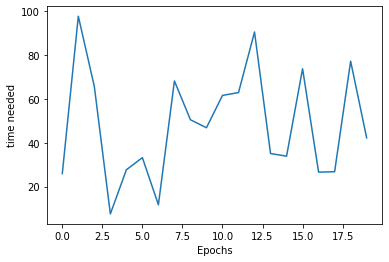

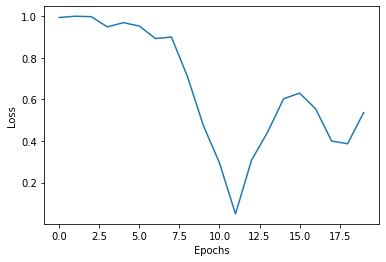

In [34]:
# Plot Figure displaying the loss each epoch
plt.figure()
plt.plot(test.times)
plt.xlabel("Epochs")
plt.ylabel("time needed")
plt.show()

# # Plot Figure displaying the needed time each epoch
plt.figure()
plt.plot(test.losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()